# Reinforcement learning : starting with Markov Decision Process and Dynamic Programming

We start by defining our problem as a Markov Decision Process.\
Then go on by trying some dynamic programming technics.

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import numpy as np

## State the problem as a Markov Decision Process (MDP)

### Environment
Let's fiddle around with the FrozenLake environment 
https://gymnasium.farama.org/environments/toy_text/frozen_lake/

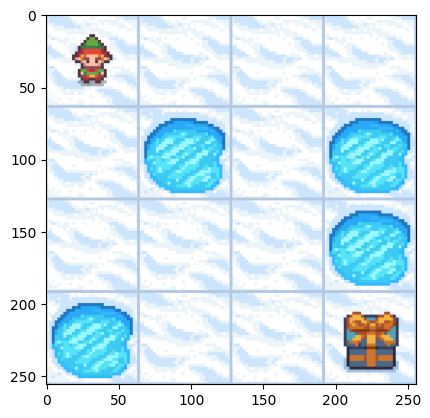

In [3]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode='rgb_array')
env.reset()
prev_screen = env.render()
plt.imshow(prev_screen)

Let's take some actions and see our character evolve in the environment with an animation.

observation : 4, reward : 0.0, terminated : False, truncated : False, info : {'prob': 1.0}


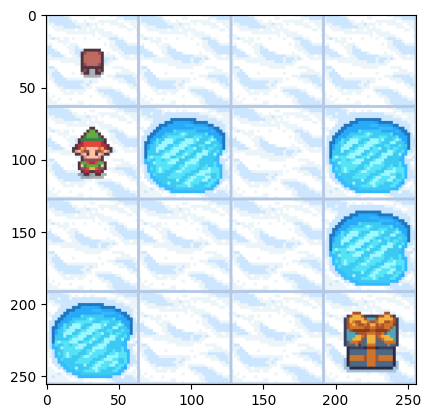

In [4]:
# derived from https://gymnasium.farama.org/content/basic_usage/
for _ in range(10):
  action = env.action_space.sample() # takes a random action
  observation, reward, terminated, truncated, info = env.step(action) # after some timesteps, the environment may end, this is called the terminal state
  screen = env.render()
  print(f"observation : {observation}, reward : {reward}, terminated : {terminated}, truncated : {truncated}, info : {info}")

  plt.imshow(screen)
  ipythondisplay.clear_output(wait=True)
  ipythondisplay.display(plt.gcf())
  
  if terminated or truncated: # If either of terminated or truncated are true then reset should be called next to restart the environment.
          observation, info = env.reset()

ipythondisplay.clear_output(wait=True)
print(f"observation : {observation}, reward : {reward}, terminated : {terminated}, truncated : {truncated}, info : {info}")
env.close()

In [5]:
# Action space
print(env.action_space) # 4 discrete actions possible for our skater (right, left, up, down)
print(env.action_space.n)

# Observation space
print(env.observation_space) # Board of 4 by 4 boxes

# Reward function
print(env.reward_range) # rewards are between 0 and 1, but in general rewards could be between -Inf, +Inf

Discrete(4)
4
Discrete(16)
(0, 1)


In our little example, the character starts at the top left corner of the board. It can move in any of the 4 directions around him.
He has a goal in his life (lucky him) to go to the bottom right corner.

He is making a step every time he does an action. At a step t, his state is his position on the board (in another game this state could have been something else, like with the CartPole, the state are values of speed, angles). Beware, the character can have a state at step t and have the same state at step t+p. 

If we observe the character moving around, we can model its states. For each state it falls into, we can associate a probability dependent on every possible states and actions in time. Now, we can simplify by assuming Markov properties, the next state depends only what already happened and more precisely only on the current state and action.

<div>
<img src="images/mdp.jpg" width="500"/>
</div>

For example, $\mathbb{P}(s_3 | s_1, a_1, s_2, a_2) = \mathbb{P}(s_3 | s_2, a_2)$.

The goal now is to find a policy, that is to say find what action to do knowing the current state.\
What could the policy optimize ? 

One answer is the total rewards $\sum_{t=0}^{\infty} r_{t}$. Let's say we have a policy, a deterministic one to simplify, that enable our character to reach the goal. We use this policy to go from start to finish, we call that an episode. At the end, I want the total reward to be as large as possible. Even if we get the largest total reward, does this mean we have the best policy ? No, it means that we have the best path from start to finish. With a different starting point, the path given by our policy would not necessarily be the best.\
Hence we want that from any state our policy provides us with the best path. The best policy is the one that returns the best total reward on average.\
The principle holds with a stochastic policy. 

The expected reward is a better answer $\mathbb{E}(\sum_{i=t}^{\infty} r_{i} | s_{t}=s)$. More precisely, we are interested in the expectancy of the discounted reward $\mathbb{E}(r_{t} + \gamma^{k}r_{t+1+k} | s_{t}=s)$. Nearby rewards in time are more interesting to us than further away ones, $\gamma$ is usually smaller than 1. The idea is that we want to find a policy that penalizes rewards too far in time.\
When do we get the rewards ? Either we know the reward function but its rarely the case, or we don't and we get rewards from the environment after doing an action from a state.

This expectancy of the discounted reward $\mathbb{E}(r_{t} + \gamma^{k}r_{t+1+k} | s_{t}=s)$ hence associate a value to each state. We could do the same to each tuple (state, action) possible $\mathbb{E}(r_{t} + \gamma^{k}r_{t+1+k} | s_{t}=s, a_{t}=a)$. Those are named respectively the value fonction and the action value fonction (also Q-value function, with Q standing for Quality). In a discrete case, we can store the Value fonction in a vector and the Action Value function is a matrix.\
This idea comes naturally when rethinking about having the best path from any starting point. Thus any state should have a value showing how much reward is expected. And on another granularity when may wonder the same for any tuple (state, action).

Note : in this example, our character has an end goal, there might none. But it is the same, after n time steps we'd like the best possible policy.

Ideally, we find the best possible Value and Q-Value function.
Let's write what the Value is $V_{\pi}(s) = \mathbb{E}(r_{t} + \gamma^{k} V_{\pi}(s_{t+1}) | s_{t}=s)$. Notice the subscript $\pi$, since the value depends on the policy. You can think of V as the average (discounted reward) over all possibles path starting from $s_t$, which is the same as taking the average of all rewards starting from $s_t$ plus the value of the respective $s_{t+1}$. Illustrated as follow.

<div>
<img src="images/vqfunctions.jpg" width="500"/>
</div>

Something important is lacking in this graph. In general we do not know the transition model, meaning we don't know in advance what is $\mathbb{P}(s'|s,a)$. A better graph would be :

<div>
<img src="images/vqfunctions_transition.jpg" width="500"/>
</div>

Knowing that a non-deterministic policy can suggest several actions, we can decompose our $V_{\pi}(s)$ as $\sum_{a}\pi(a|s)\sum_{s', r}$

The best V and Q function are obtained for the best policy. In that case the policy becomes deterministic, it is the one that yields the best value for any state.
We get 

## Dynamic Programming

Dynamic Programming methods can find the optimal policy.\
Under the assumptions that all is known about the MDP, like the states and actions.\
But reinforcement learning applies when transition and reward functions are unknown.

Going back to the previous cell, by rewriting the expected dicounted reward we get a recursive formula. The expected discounted reward at time t is an operation on the expected discounted reward at time t-1.\ [equation]
It's different whether the policy is deterministic or stochastic.  [equation]

To go from t to t+1 for the Value function, we define an operator, which has a contractive property in the discounted case. This operator is the Bellman optimality operator.[equation] 

We also have a theorem about contractive operators providing us with a convergence to a fixed-point.[equation]\
At convergence we have an optimal Value function AND an optimal policy. Iterating over until convergence is a method called Value Iteration.

Value Iteration is not the only algorithm, let's seen another one. we define the Bellman operator and its accompanying method called Policy Iteration. There are 2 phases, policy evaluation and policy improvement if needed.

### Value Iteration

[pseudocode]

In [11]:
map_side = 4
theta = 0.1
gamma = 0.8

# Initialize V(s) with random values and 0 for the terminal states 
# for more convenience, V is a matrix reflecting the board
V =  np.random.rand(env.observation_space.n)
# 0 for the terminal state
V[15] = 0
V

array([0.31862346, 0.30967967, 0.5873733 , 0.08630552, 0.7145944 ,
       0.82412872, 0.52597625, 0.72408612, 0.34203294, 0.84381948,
       0.20093833, 0.73785286, 0.32992704, 0.60908643, 0.13530184,
       0.        ])

In [12]:
env.P[0]

{0: [(1.0, 0, 0.0, False)],
 1: [(1.0, 4, 0.0, False)],
 2: [(1.0, 1, 0.0, False)],
 3: [(1.0, 0, 0.0, False)]}

In [ ]:
def value_iteration(env, gamma=0.99, epsilon=1e-6):
    num_states = env.observation_space.n
    num_actions = env.action_space.n

    # Initialize value function with zeros
    V = np.zeros(num_states)

    while True:
        delta = 0
        for s in range(num_states):
            v = V[s]
            action_values = np.zeros(num_actions)
            
            # Calculate action values
            for a in range(num_actions):
                for prob, next_s, reward, _ in env.P[s][a]:
                    action_values[a] += prob * (reward + gamma * V[next_s])

            # Update value function with the maximum action value
            V[s] = np.max(action_values)
            delta = max(delta, np.abs(v - V[s]))

        # Check for convergence
        if delta < epsilon:
            break

    # Derive the optimal policy
    policy = np.zeros(num_states, dtype=int)
    for s in range(num_states):
        action_values = np.zeros(num_actions)
        for a in range(num_actions):
            for prob, next_s, reward, _ in env.P[s][a]:
                action_values[a] += prob * (reward + gamma * V[next_s])

        policy[s] = np.argmax(action_values)

    return V, policy

### Policy Iteration